In [1]:
from time_lstm import T1TimeLSTM, T2TimeLSTM
from dataset_delay_predictions import Dataset_Delay_Prediction, Dataset_Delay_Prediction_from_list, DatasetDelayPredictionStackOverflow
from time_dependant_representation import TimeDepMasking, TimeDepJointEmbedding
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Masking, Layer, LSTM
import os
import tensorflow as tf
import pickle
from matplotlib import pyplot as plt

In [2]:
dataset_names = [
    '2019-10_11_12-dataset_delay_prediction',
    'stack-overflow-dataset'
]

In [3]:
dataset_name = dataset_names[1]
pickle_filename = dataset_name.replace('/', '-')
if os.path.exists(pickle_filename):
    print('Reading pickle file...')
    dataset = pickle.load(open(pickle_filename, 'rb'))

Reading pickle file...


In [4]:
#training_set_length = dataset.training_set_length
training_set_length = dataset.training_set_length
print(training_set_length)
X_train = dataset.full_features_log_dt[:training_set_length]
seqlen = dataset.full_seqlen[:training_set_length]
y_train = np.array(dataset.full_values[:training_set_length])
print(y_train.shape)
#y_train = np.array(dataset.next_event[:training_set_length])
print(y_train.shape)

5306
(5306, 1)
(5306, 1)


In [5]:
test_set_length = len(dataset.full_features_log_dt) - training_set_length
X_test = dataset.full_features_log_dt[training_set_length:]
seqlen_test = dataset.full_seqlen[training_set_length:]
y_test = np.array(dataset.full_values[training_set_length:])
#y_test = np.array(dataset.next_event[training_set_length:])
print(y_test.shape)

(1327, 1)


In [6]:
print(y_test[:5])

[[0.01085006]
 [0.00470769]
 [0.17289315]
 [0.09705887]
 [0.02196756]]


In [7]:
padding_value = 0.123456789
padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                              padding='post',
                                                              value=padding_value,
                                                              dtype='float32')
print(padded_inputs.shape)

(5306, 735, 24)


In [12]:
lstm_units = 50
activation_fn = 'linear'

number_of_epochs = 20
history = {}
precision= {}

In [13]:
#LSTMUni

In [14]:
method = 'LSTMUni'
X_train_uni = [[[feat[-2]] for feat in x] for x in X_train]
padded_inputs_uni = tf.keras.preprocessing.sequence.pad_sequences(X_train_uni,
                                                              padding='post',
                                                              value=padding_value,
                                                              dtype='float32')


In [15]:
print('size of input tensor: ',)
print(padded_inputs_uni.shape)
regressorLSTMUni = Sequential()
regressorLSTMUni.add(Masking(mask_value=padding_value))
regressorLSTMUni.add(LSTM(units=lstm_units))
regressorLSTMUni.add(Dense(units=y_train.shape[1], activation=activation_fn))
regressorLSTMUni.compile(optimizer='adam', loss='mean_squared_error')
history[method] = regressorLSTMUni.fit(padded_inputs_uni, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)

size of input tensor: 
(5306, 735, 1)
Train on 5306 samples
Epoch 1/20
5306/5306 [==============================] - 60s 11ms/sample - loss: 0.0076
Epoch 2/20
5306/5306 [==============================] - 57s 11ms/sample - loss: 0.0070
Epoch 3/20
5306/5306 [==============================] - 61s 12ms/sample - loss: 0.0070
Epoch 4/20
5306/5306 [==============================] - 62s 12ms/sample - loss: 0.0070
Epoch 5/20
5306/5306 [==============================] - 61s 11ms/sample - loss: 0.0069
Epoch 6/20
5306/5306 [==============================] - 60s 11ms/sample - loss: 0.0070
Epoch 7/20
5306/5306 [==============================] - 55s 10ms/sample - loss: 0.0069
Epoch 8/20
5306/5306 [==============================] - 54s 10ms/sample - loss: 0.0069
Epoch 9/20
5306/5306 [==============================] - 54s 10ms/sample - loss: 0.0069
Epoch 10/20
5306/5306 [==============================] - 53s 10ms/sample - loss: 0.0069
Epoch 11/20
5306/5306 [==============================] - 53s 10ms/sam

In [16]:
X_test = dataset.full_features_log_dt[training_set_length:]
seqlen_test = dataset.full_seqlen[training_set_length:]
y_test = np.array(dataset.next_event[training_set_length:])
y_test = np.array(dataset.full_values[training_set_length:])
X_test_uni = []
number_of_event = len(X_train[0][0])
for idx in range(test_set_length):
    seq = X_test[idx]
    ts_list = [[a[-2]] for a in seq]
    X_test_uni.append(ts_list)
X_test_uni = [[[seq[-2]] for seq in x] for x in X_test]

In [17]:
padding_value = 0.123456789
padded_inputs_test_uni = tf.keras.preprocessing.sequence.pad_sequences(X_test_uni,
                                                              padding='post',
                                                              value=padding_value,
                                                              dtype='float32')
pred = regressorLSTMUni.predict(padded_inputs_test_uni)


In [ ]:
prec = 0
for pred_, y_ in zip(pred,y_test):
    prec += np.argmax(pred_) == np.argmax(y_)
print(prec)
print(len(pred))
prec /= len(pred)
precision[method] = prec
print(precision)

In [19]:
MSE = {}
mean_sum_of_squares = sum([(y_test[i] - pred[i])**2 for i in range(test_set_length)])/test_set_length
print(mean_sum_of_squares)
MSE[method] = mean_sum_of_squares[0]
print(MSE)

[0.00494943]
{'LSTMUni': 0.0049494293926578585}


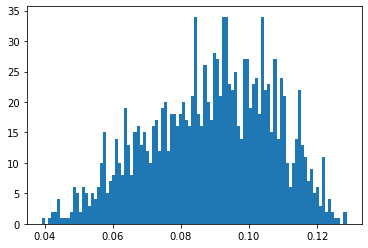

In [20]:
outputs = [pred_[0] for pred_ in pred]
plt.hist(outputs, bins=100)
plt.show()

1327


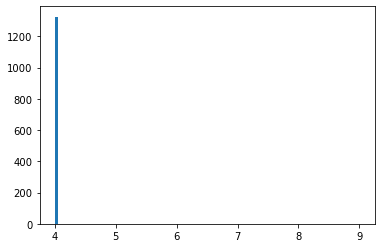

In [88]:
target_val = np.argmax(pred, axis=1) + 1
print(len(target_val))
plt.hist(target_val, bins=100)
plt.show()

## LSTM Multi

In [21]:
method = 'LSTMMulti'

In [22]:
print('size of input tensor: ',)
print(padded_inputs.shape)
regressorLSTMMulti = Sequential()
regressorLSTMMulti.add(Masking(mask_value=padding_value))
regressorLSTMMulti.add(LSTM(units=lstm_units))
regressorLSTMMulti.add(Dense(units=y_train.shape[1], activation=activation_fn))


regressorLSTMMulti.compile(optimizer='adam', loss='mean_squared_error')
history[method] = regressorLSTMMulti.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)

size of input tensor: 
(5306, 735, 24)
Train on 5306 samples
Epoch 1/20
5306/5306 [==============================] - 61s 12ms/sample - loss: 0.0324
Epoch 2/20
5306/5306 [==============================] - 57s 11ms/sample - loss: 0.0075
Epoch 3/20
5306/5306 [==============================] - 58s 11ms/sample - loss: 0.0074
Epoch 4/20
5306/5306 [==============================] - 58s 11ms/sample - loss: 0.0074
Epoch 5/20
5306/5306 [==============================] - 58s 11ms/sample - loss: 0.0073
Epoch 6/20
5306/5306 [==============================] - 58s 11ms/sample - loss: 0.0073
Epoch 7/20
5306/5306 [==============================] - 58s 11ms/sample - loss: 0.0073
Epoch 8/20
5306/5306 [==============================] - 57s 11ms/sample - loss: 0.0073
Epoch 9/20
5306/5306 [==============================] - 57s 11ms/sample - loss: 0.0073
Epoch 10/20
5306/5306 [==============================] - 56s 11ms/sample - loss: 0.0073
Epoch 11/20
5306/5306 [==============================] - 56s 11ms/sa

In [23]:
padded_inputs_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                              padding='post',
                                                              value=padding_value,
                                                              dtype='float32')
predLSTMMulti = regressorLSTMMulti.predict(padded_inputs_test)


In [ ]:
prec = 0
for pred_, y_ in zip(predLSTMMulti,y_test):
    prec += np.argmax(pred_) == np.argmax(y_)
print(prec)
prec /= len(pred)
precision[method] = prec
print(precision)

[4 4 4 ... 4 4 4]
1327


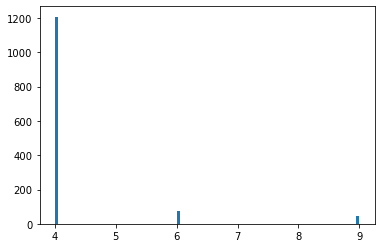

In [92]:
target_val = np.argmax(predLSTMMulti, axis=1)
print(target_val+1)
print(len(target_val))
plt.hist(target_val+1, bins=100)
plt.show()

In [24]:
mean_sum_of_squares = sum([(y_test[i] - predLSTMMulti[i])**2 for i in range(test_set_length)])/test_set_length
print(mean_sum_of_squares)
MSE[method] = mean_sum_of_squares[0]
print(MSE)

[0.00541051]
{'LSTMUni': 0.0049494293926578585, 'LSTMMulti': 0.00541050901253107}


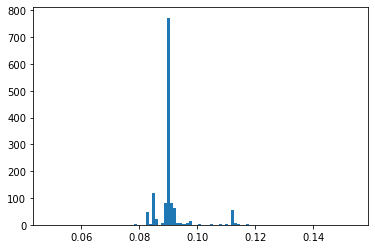

In [25]:
outputs = [pred_[0] for pred_ in predLSTMMulti]
plt.hist(outputs, bins=100)
plt.show()

## T1TimeLSTM

In [26]:
method = 'T1TimeLSTM'

In [27]:
print(padded_inputs.shape)
regressorT1TimeLSTM = Sequential()
regressorT1TimeLSTM.add(Masking(mask_value=padding_value))
regressorT1TimeLSTM.add(T1TimeLSTM(units=lstm_units))
regressorT1TimeLSTM.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressorT1TimeLSTM.compile(optimizer='adam', loss='mean_squared_error')
history = regressorT1TimeLSTM.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)


(5306, 735, 24)
Train on 5306 samples
Epoch 1/20
5306/5306 [==============================] - 92s 17ms/sample - loss: 0.0071
Epoch 2/20
5306/5306 [==============================] - 85s 16ms/sample - loss: 0.0069
Epoch 3/20
5306/5306 [==============================] - 84s 16ms/sample - loss: 0.0069
Epoch 4/20
5306/5306 [==============================] - 83s 16ms/sample - loss: 0.0068
Epoch 5/20
5306/5306 [==============================] - 82s 15ms/sample - loss: 0.0068
Epoch 6/20
5306/5306 [==============================] - 81s 15ms/sample - loss: 0.0068
Epoch 7/20
5306/5306 [==============================] - 81s 15ms/sample - loss: 0.0068
Epoch 8/20
5306/5306 [==============================] - 81s 15ms/sample - loss: 0.0067
Epoch 9/20
5306/5306 [==============================] - 81s 15ms/sample - loss: 0.0066
Epoch 10/20
5306/5306 [==============================] - 81s 15ms/sample - loss: 0.0066
Epoch 11/20
5306/5306 [==============================] - 133s 25ms/sample - loss: 0.0067
Ep

In [28]:
predT1TimeLSTM = regressorT1TimeLSTM.predict(padded_inputs_test)


In [29]:
mean_sum_of_squares = sum([(y_test[i] - predT1TimeLSTM[i])**2 for i in range(test_set_length)])/test_set_length
print(mean_sum_of_squares)
MSE[method] = mean_sum_of_squares[0]
print(MSE)

[0.0049336]
{'LSTMUni': 0.0049494293926578585, 'LSTMMulti': 0.00541050901253107, 'T1TimeLSTM': 0.004933604890250341}


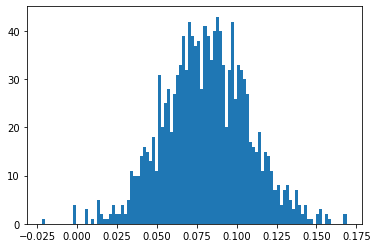

In [30]:
outputs = [pred_[0] for pred_ in predT1TimeLSTM]
plt.hist(outputs, bins=100)
plt.show()

In [ ]:
prec = 0
for pred_, y_ in zip(predT1TimeLSTM,y_test):
    prec += np.argmax(pred_) == np.argmax(y_)
print(prec)
prec /= len(pred)
precision[method] = prec
print(precision)

1327


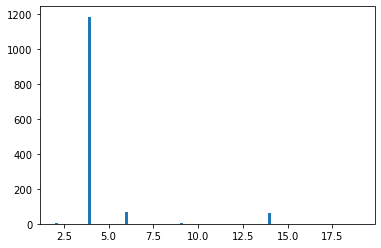

In [106]:
target_val = np.argmax(predT1TimeLSTM, axis=1) + 1
print(len(target_val))
plt.hist(target_val, bins=100)
plt.show()

In [108]:
unique, counts = np.unique(target_val, return_counts=True)
dict(zip(unique, counts))

{2: 3, 4: 1186, 6: 67, 9: 7, 14: 63, 19: 1}

In [112]:
target_val = np.argmax(y_test, axis=1) + 1
unique, counts = np.unique(target_val, return_counts=True)
dict(zip(unique, counts))


{1: 73,
 2: 14,
 3: 4,
 4: 602,
 5: 93,
 6: 57,
 7: 25,
 9: 376,
 10: 15,
 11: 1,
 12: 13,
 13: 11,
 14: 32,
 15: 3,
 16: 1,
 19: 7}

In [111]:
y_test[:2]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]])

## T2TimeLSTM

In [ ]:
method = 'T2TimeLSTM'
print(padded_inputs.shape)
regressor = Sequential()
regressor.add(Masking(mask_value=padding_value))
regressor.add(T2TimeLSTM(units=lstm_units))
regressor.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressor.compile(optimizer='adam', loss='mean_squared_error')
history = regressor.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)


(5306, 735, 24)
Train on 5306 samples
Epoch 1/20
5306/5306 [==============================] - 118s 22ms/sample - loss: 0.0078
Epoch 2/20
5306/5306 [==============================] - 114s 21ms/sample - loss: 0.0070
Epoch 3/20
5306/5306 [==============================] - 103s 19ms/sample - loss: 0.0069
Epoch 4/20
5306/5306 [==============================] - 103s 19ms/sample - loss: 0.0068
Epoch 5/20
4250/5306 [=======================>......] - ETA: 20s - loss: 0.0068

In [ ]:
predT2TimeLSTM = regressor.predict(padded_inputs_test)


In [ ]:
mean_sum_of_squares = sum([(y_test[i] - predT2TimeLSTM[i])**2 for i in range(test_set_length)])/test_set_length
print(mean_sum_of_squares)
MSE[method] = mean_sum_of_squares[0]
print(MSE)


In [ ]:
outputs = [pred_[0] for pred_ in predT2TimeLSTM]
plt.hist(outputs, bins=100)
plt.show()

In [ ]:
prec = 0
for pred_, y_ in zip(predT2TimeLSTM,y_test):
    prec += np.argmax(pred_) == np.argmax(y_)
print(prec)
prec /= len(pred)
precision[method] = prec
print(precision)

[ 4  6  4 ... 14  4 14]
1327


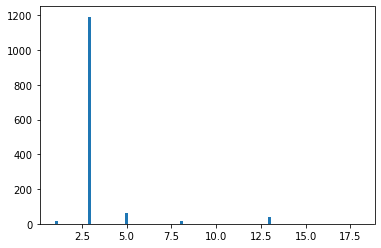

In [99]:
target_val = np.argmax(predT2TimeLSTM, axis=1)
print(target_val+1)
print(len(target_val))
plt.hist(target_val, bins=100)
plt.show()

## TimeDepJointEmbedding

In [ ]:
method = 'TimeDepJointEmbedding'
print(padded_inputs.shape)
regressor = Sequential()
regressor.add(Masking(mask_value=padding_value))
regressor.add(TimeDepJointEmbedding(units=lstm_units))
regressor.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressor.compile(optimizer='adam', loss='mean_squared_error')
history = regressor.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)
X_test = np.array([padded_inputs[0, :, :]])

In [ ]:
predTimeDep = regressor.predict(padded_inputs_test)


In [ ]:
mean_sum_of_squares = sum([(y_test[i] - predTimeDep[i])**2 for i in range(test_set_length)])/test_set_length
print(mean_sum_of_squares)
MSE[method] = mean_sum_of_squares[0]
print(MSE)


In [ ]:
outputs = [pred_[0] for pred_ in predTimeDeP]
plt.hist(outputs, bins=100)
plt.show()

In [ ]:
prec = 0
for pred_, y_ in zip(predTimeDep,y_test):
    prec += np.argmax(pred_) == np.argmax(y_)
print(prec)
prec /= len(pred)
precision[method] = prec
print(precision)

[ 4  4  4 ...  6  4 14]
1327


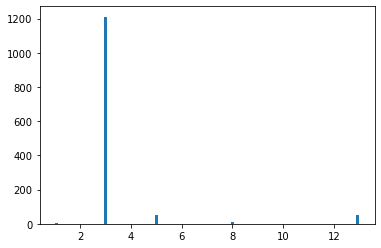

In [102]:
target_val = np.argmax(predTimeDep, axis=1)
print(target_val+1)
print(len(target_val))
plt.hist(target_val, bins=100)
plt.show()

In [103]:
from matplotlib import pyplot as plt

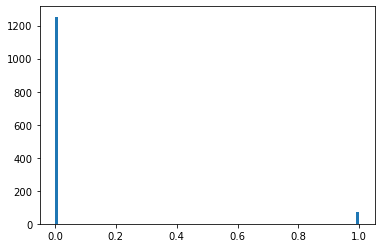

In [104]:
target_values = [val[0] for val in y_test]
plt.hist(target_values, bins=100)
plt.show()

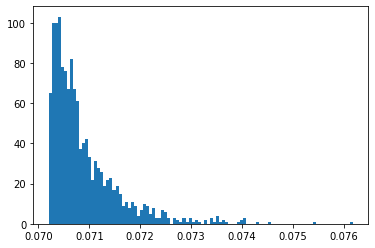

In [105]:
target_values = [val[0] for val in pred]
plt.hist(target_values, bins=100)
plt.show()

In [ ]:
average_target = y_train.mean()
print(average_target)

In [ ]:
MSE = sum([(average_target - y_test_val[0])**2 for y_test_val in y_test])/len(y_test)
print(MSE)

In [ ]:
print(MSE)

In [ ]:
print(dataset.next_event[:10])

KeyboardInterrupt: 

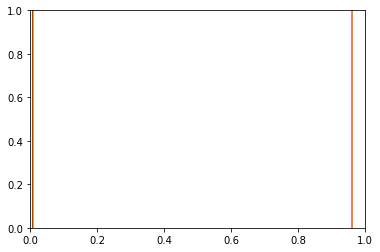

In [138]:
plt.hist(dataset.next_event, bins=22)
plt.show()

In [152]:
dataset_name = dataset_names[0]
pickle_filename = dataset_name.replace('/', '-')
if os.path.exists(pickle_filename):
    print('Reading pickle file...')
    dataset = pickle.load(open(pickle_filename, 'rb'))

Reading pickle file...


In [143]:
A = np.array(dataset.next_event)

In [147]:
B = np.array([np.argmax(a) for a in A]) + 1

In [148]:
B[:10]

array([4, 5, 2, 4, 5, 6, 4, 6, 9, 4])

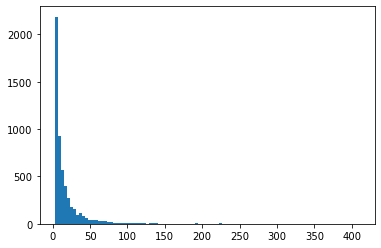

In [155]:
plt.hist(dataset.full_seqlen, bins=100)
plt.show()

In [160]:
seqlen = np.array(dataset.full_seqlen)
print(max(seqlen))
print(min(seqlen))
print(len(seqlen))

410
3
5468


No handles with labels found to put in legend.


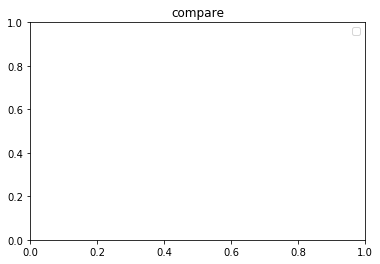

In [156]:
x = [0.00001,0.001,0.01,0.1,0.5,1,5]
# create an index for each tick position


plt.title('compare')
plt.legend() 
plt.show()